In [0]:
import os

In [0]:
!ls -la
!rm -r WallClassification
!ls -la

total 44
drwxr-xr-x 1 root root 4096 Jul 29 00:09 .
drwxr-xr-x 1 root root 4096 Jul 29 00:05 ..
drwx------ 4 root root 4096 Jul 29 00:07 .cache
drwxr-xr-x 3 root root 4096 Jul 29 00:07 .config
drwxr-xr-x 3 root root 4096 Jul 26 16:56 datalab
drwxr-xr-x 4 root root 4096 Jul 29 00:06 .forever
drwxr-xr-x 5 root root 4096 Jul 29 00:07 .ipython
drwxr-xr-x 3 root root 4096 Jul 29 00:09 .keras
drwx------ 3 root root 4096 Jul 29 00:06 .local
drwx------ 3 root root 4096 Jul 29 00:09 .nv
drwxr-xr-x 9 root root 4096 Jul 29 09:46 WallClassification
total 40
drwxr-xr-x 1 root root 4096 Jul 29 10:36 .
drwxr-xr-x 1 root root 4096 Jul 29 00:05 ..
drwx------ 4 root root 4096 Jul 29 00:07 .cache
drwxr-xr-x 3 root root 4096 Jul 29 00:07 .config
drwxr-xr-x 3 root root 4096 Jul 26 16:56 datalab
drwxr-xr-x 4 root root 4096 Jul 29 00:06 .forever
drwxr-xr-x 5 root root 4096 Jul 29 00:07 .ipython
drwxr-xr-x 3 root root 4096 Jul 29 00:09 .keras
drwx------ 3 root root 4096 Jul 29 00:06 .local
drwx------ 3 root r

In [0]:
# 今回使用するレポジトリをGoogle Colabの環境にクローン https://github.com/shuuichi/WallClassification
# !git clone https://github.com/s0yamazaki/WallClassification.git
!git clone https://github.com/shuuichi/WallClassification.git
  

Cloning into 'WallClassification'...
remote: Counting objects: 31404, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 31404 (delta 2), reused 0 (delta 0), pack-reused 31398
Receiving objects: 100% (31404/31404), 331.95 MiB | 38.68 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [5]:
# メインスクリプトの格納ディレクトリに移動
os.chdir('WallClassification')
!ls

FileNotFoundError: ignored

In [0]:
# 生成されたファイルとディレクトリを表示
print('* カレントディレクトリ')
!ls .
print('\n* testmodel ディレクトリ')
!ls ./testmodel

* カレントディレクトリ
classes_extractor.py  googleImageDownloader.json  resize.py
continue_fit.py       model.py			  semi-teching.py
crop.py		      resized_cleaned		  WallClassification.ipynb
erase_duplicates.py   resized_val

* testmodel ディレクトリ
ls: cannot access './testmodel': No such file or directory


In [0]:
import pandas as pd
import matplotlib.pyplot as plt

def aclosplot(filename):
    # Read file
    df = pd.read_csv(filename)

    # Set values
    # epoch,acc,loss,val_acc,val_loss
    x = df['epoch'].values
    y0 = df['acc'].values
    y1 = df['loss'].values
    y2 = df['val_acc'].values
    y3 = df['val_loss'].values

    # Set background color to white
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    # Plot lines
    plt.xlabel('epoch')
    plt.plot(x, y0, label='train_accuracy')
    plt.plot(x, y2, label='validation_accuracy')
    # plt.plot(x, y1, label='train_los')
    # plt.plot(x, y3, label='validation_loss')
    plt.legend()

    # Visualize
    plt.show()
    
    
    # Plot lines
    plt.xlabel('epoch')
    # plt.plot(x, y0, label='train_accuracy')
    # plt.plot(x, y2, label='validation_accuracy')
    plt.plot(x, y1, label='train_los')
    plt.plot(x, y3, label='validation_loss')
    plt.legend()

    plt.show()
    

# エポック数を100に

In [0]:
"""
サンプルのモデルの定義と訓練を行うモジュール
vgg16をベースにした転移学習モデルとなっている。
"""
from keras.models import Model,Sequential
import tensorflow as tf
from keras.layers.convolutional import Conv2D
from keras.layers import Activation, Dense, GlobalAveragePooling2D, Input, InputLayer, Lambda, Dropout, BatchNormalization,LeakyReLU
from keras.backend import sigmoid
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam
from keras.callbacks import CSVLogger
from keras.callbacks import TensorBoard, EarlyStopping
import sys
import numpy as np
from collections import Counter
import continue_fit as cf
from keras.utils import multi_gpu_model
from keras import regularizers

def vgg_based_model(input_shape, n_categories, fulltraining = False):
    """
    VGG16をベースにした転移学習モデルを生成する。
    fulltraining: Trueにすると、ベースモデルも含めて訓練可能にする。訓練速度が非常に遅くなる。
    """
    base_model=VGG16(weights='imagenet',include_top=False,
                    input_tensor=Input(shape=input_shape))

    #add new layers instead of FC networks
    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(1024)(x)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    x=Dropout(0.6)(x)
    x=Dense(1024)(x)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    x=Dropout(0.6)(x)
    prediction=Dense(n_categories,activation='softmax')(x)
    model=Model(inputs=base_model.input,outputs=prediction)

    if not fulltraining:
        # fix weights before VGG16 14layers
        for layer in base_model.layers[:15]:
            layer.trainable=False
    return model


In [0]:
# コマンドライン引数の定義/評価
batch_size=32
input_shape = (224,224,3)
#  parser = argparse.ArgumentParser()
# parser.add_argument("model_name", help="保存するモデルファイルの名前、兼tensorBoardのログディレクトリ名")
# parser.add_argument("-t", "--train_dir", default='resized_cleaned', help="トレーニングデータセットが入っているディレクトリ")
# parser.add_argument("-v","--validation_dir",default='resized_val', help ="バリデーションデータセットが入っているディレクトリ")
# args = parser.parse_args()


file_name = 'test00' #args.model_name
train_dir= 'resized_cleaned' # args.train_dir
validation_dir= 'resized_val' # args.validation_dir

#訓練データの読み込み及びデータ拡張を行うための画像ジェネレータを生成。
#VGG16用の前処理及び平行移動、回転、左右反転、シアー変換をランダムにかける。
train_datagen=ImageDataGenerator(
    preprocessing_function=preprocess_input, #VGG16の前処理
    height_shift_range=0.02,
    width_shift_range=0.02,
    shear_range=0.05,
    zoom_range=0.05,
    rotation_range=5,
    horizontal_flip=True,
    )
train_generator=train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[0:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
    )


n_categories=len(train_generator.class_indices)
#サンプルの多いクラスに予測が集中しないように、少ないサンプルのクラスほど重くなるように重みづけ
class_weight ={ clss: len(train_generator.classes) / len(train_generator.class_indices) / count
                 for (clss,count) in Counter(train_generator.classes).most_common() }
print("classes:",train_generator.class_indices)
print("class weight:",class_weight)

#バリデーションデータの画像読み込み処理を行うジェネレータを生成
validation_datagen=ImageDataGenerator(
    preprocessing_function=preprocess_input,
    )
validation_generator=validation_datagen.flow_from_directory(
    validation_dir,
    target_size=input_shape[0:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

model = vgg_based_model(input_shape, n_categories)
# parallel_model = multi_gpu_model(model, gpus=2)   #マルチGPUを使うときはこちら

model.compile(optimizer=Adam(lr=1e-3),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

#訓練(中断しても続きから継続できる)
hist=model.fit_generator(
    train_generator,
    epochs=100,
    #initial_epoch=cf.load_epoch_init(file_name), # 同じモデル名でも結果を引き継がないようにコメントアウト
    # use_multiprocessing=True,
    verbose=1,
    workers=8,
    validation_data=validation_generator,
    class_weight=class_weight,
    callbacks=[
        CSVLogger(file_name+'.csv'),
        TensorBoard(file_name),
        cf.early_stopping(model, file_name),
        ])

Found 5234 images belonging to 11 classes.
classes: {'ALC板': 0, 'ガラスカーテンウォール': 1, 'ガラスブロック': 2, 'コンクリートブロック': 3, 'コンクリート打ち放し': 4, 'スパンドレル': 5, 'スレート波板張り': 6, 'タイル張り': 7, '吹付タイル': 8, '押出成形セメント板': 9, '石張り': 10}
class weight: {7: 0.38527788001472213, 1: 0.48701963338606125, 3: 0.6000229278917804, 4: 0.8994672624162227, 5: 0.967110125646711, 0: 1.310793889306286, 2: 1.6295143212951433, 9: 2.0687747035573123, 8: 2.44009324009324, 10: 5.4070247933884295, 6: 11.895454545454545}
Found 1020 images belonging to 11 classes.
Epoch 1/100
161/164 [============================>.] - ETA: 1s - loss: 2.7617 - acc: 0.1914

164/164 [==============================] - 83s 509ms/step - loss: 2.7490 - acc: 0.1924 - val_loss: 3.5454 - val_acc: 0.2167
Epoch 2/100
164/164 [==============================] - 76s 460ms/step - loss: 1.9824 - acc: 0.3388 - val_loss: 1.9230 - val_acc: 0.3931
Epoch 3/100
164/164 [==============================] - 75s 460ms/step - loss: 1.6962 - acc: 0.3866 - val_loss: 1.9000 - val_acc: 0.4245
Epoch 4/100
 11/164 [=>............................] - ETA: 52s - loss: 1.8304 - acc: 0.5000

164/164 [==============================] - 75s 460ms/step - loss: 1.5279 - acc: 0.4742 - val_loss: 2.1776 - val_acc: 0.3225
Epoch 5/100
164/164 [==============================] - 75s 460ms/step - loss: 1.3415 - acc: 0.5401 - val_loss: 1.6575 - val_acc: 0.4716
Epoch 6/100
147/164 [=========================>....] - ETA: 6s - loss: 1.2116 - acc: 0.5703

164/164 [==============================] - 76s 461ms/step - loss: 1.1852 - acc: 0.5746 - val_loss: 1.2218 - val_acc: 0.6216
Epoch 7/100
164/164 [==============================] - 77s 471ms/step - loss: 1.0492 - acc: 0.6134 - val_loss: 1.2644 - val_acc: 0.5824
Epoch 8/100
164/164 [==============================] - 77s 469ms/step - loss: 1.0720 - acc: 0.6106 - val_loss: 2.7799 - val_acc: 0.3814
Epoch 9/100
  9/164 [>.............................] - ETA: 53s - loss: 1.0720 - acc: 0.6215

164/164 [==============================] - 78s 476ms/step - loss: 0.9562 - acc: 0.6515 - val_loss: 1.2966 - val_acc: 0.6000
Epoch 10/100
164/164 [==============================] - 75s 459ms/step - loss: 0.8666 - acc: 0.6818 - val_loss: 1.4436 - val_acc: 0.5922
Epoch 11/100
145/164 [=========================>....] - ETA: 7s - loss: 0.8493 - acc: 0.6774

164/164 [==============================] - 76s 463ms/step - loss: 0.8422 - acc: 0.6778 - val_loss: 1.3137 - val_acc: 0.5980
Epoch 12/100
164/164 [==============================] - 75s 456ms/step - loss: 0.7371 - acc: 0.7192 - val_loss: 1.1552 - val_acc: 0.6412
Epoch 13/100
164/164 [==============================] - 75s 457ms/step - loss: 0.7258 - acc: 0.7290 - val_loss: 1.6563 - val_acc: 0.5451
Epoch 14/100
  7/164 [>.............................] - ETA: 54s - loss: 0.5942 - acc: 0.7366

164/164 [==============================] - 75s 458ms/step - loss: 0.6709 - acc: 0.7433 - val_loss: 1.3512 - val_acc: 0.6235
Epoch 15/100
164/164 [==============================] - 75s 455ms/step - loss: 0.6318 - acc: 0.7584 - val_loss: 1.5879 - val_acc: 0.5794
Epoch 16/100
144/164 [=========================>....] - ETA: 8s - loss: 0.5941 - acc: 0.7669

164/164 [==============================] - 76s 461ms/step - loss: 0.5899 - acc: 0.7666 - val_loss: 1.2728 - val_acc: 0.6539
Epoch 17/100
164/164 [==============================] - 74s 453ms/step - loss: 0.5494 - acc: 0.7858 - val_loss: 1.2491 - val_acc: 0.6559
Epoch 18/100
164/164 [==============================] - 76s 466ms/step - loss: 0.4708 - acc: 0.8086 - val_loss: 2.3515 - val_acc: 0.5108
Epoch 19/100
  7/164 [>.............................] - ETA: 53s - loss: 0.5328 - acc: 0.8036

164/164 [==============================] - 75s 455ms/step - loss: 0.4989 - acc: 0.8137 - val_loss: 1.4626 - val_acc: 0.6529
Epoch 20/100
164/164 [==============================] - 75s 459ms/step - loss: 0.4730 - acc: 0.8207 - val_loss: 1.3271 - val_acc: 0.6775
Epoch 21/100
144/164 [=========================>....] - ETA: 7s - loss: 0.4668 - acc: 0.8146

164/164 [==============================] - 76s 461ms/step - loss: 0.4557 - acc: 0.8153 - val_loss: 1.3832 - val_acc: 0.6667
Epoch 22/100
164/164 [==============================] - 75s 455ms/step - loss: 0.3591 - acc: 0.8512 - val_loss: 1.4147 - val_acc: 0.6520
Epoch 23/100
164/164 [==============================] - 74s 452ms/step - loss: 0.2898 - acc: 0.8774 - val_loss: 1.4874 - val_acc: 0.6520
Epoch 24/100
  7/164 [>.............................] - ETA: 53s - loss: 0.2591 - acc: 0.8616

164/164 [==============================] - 76s 461ms/step - loss: 0.2750 - acc: 0.8859 - val_loss: 1.4832 - val_acc: 0.6873
Epoch 25/100
164/164 [==============================] - 75s 460ms/step - loss: 0.2776 - acc: 0.8896 - val_loss: 2.3777 - val_acc: 0.5431
Epoch 26/100
144/164 [=========================>....] - ETA: 8s - loss: 0.3798 - acc: 0.8474

164/164 [==============================] - 76s 466ms/step - loss: 0.3852 - acc: 0.8447 - val_loss: 1.5293 - val_acc: 0.6716
Epoch 27/100
164/164 [==============================] - 74s 453ms/step - loss: 0.2601 - acc: 0.8919 - val_loss: 1.3060 - val_acc: 0.6990
Epoch 28/100
164/164 [==============================] - 76s 461ms/step - loss: 0.2116 - acc: 0.9147 - val_loss: 1.3871 - val_acc: 0.7000
Epoch 29/100
  7/164 [>.............................] - ETA: 54s - loss: 0.1547 - acc: 0.9375

164/164 [==============================] - 76s 465ms/step - loss: 0.2169 - acc: 0.9082 - val_loss: 1.8759 - val_acc: 0.6196
Epoch 30/100
164/164 [==============================] - 77s 472ms/step - loss: 0.2002 - acc: 0.9136 - val_loss: 1.7167 - val_acc: 0.6333
Epoch 31/100
144/164 [=========================>....] - ETA: 8s - loss: 0.1625 - acc: 0.9338

164/164 [==============================] - 78s 473ms/step - loss: 0.1642 - acc: 0.9322 - val_loss: 1.5604 - val_acc: 0.6775
Epoch 32/100
164/164 [==============================] - 76s 460ms/step - loss: 0.1314 - acc: 0.9429 - val_loss: 1.4941 - val_acc: 0.6951
Epoch 33/100
164/164 [==============================] - 75s 456ms/step - loss: 0.1362 - acc: 0.9393 - val_loss: 2.1990 - val_acc: 0.6304
Epoch 34/100
  7/164 [>.............................] - ETA: 53s - loss: 0.1844 - acc: 0.9286

164/164 [==============================] - 74s 450ms/step - loss: 0.1995 - acc: 0.9240 - val_loss: 1.6310 - val_acc: 0.6922
Epoch 35/100
164/164 [==============================] - 74s 449ms/step - loss: 0.2131 - acc: 0.9103 - val_loss: 1.7596 - val_acc: 0.6716
Epoch 36/100
144/164 [=========================>....] - ETA: 7s - loss: 0.1942 - acc: 0.9217

164/164 [==============================] - 75s 455ms/step - loss: 0.1889 - acc: 0.9231 - val_loss: 1.4596 - val_acc: 0.6980
Epoch 37/100
164/164 [==============================] - 73s 448ms/step - loss: 0.1529 - acc: 0.9375 - val_loss: 1.6197 - val_acc: 0.6863
Epoch 38/100
164/164 [==============================] - 75s 457ms/step - loss: 0.1091 - acc: 0.9533 - val_loss: 1.6778 - val_acc: 0.6794
Epoch 39/100
  7/164 [>.............................] - ETA: 53s - loss: 0.0888 - acc: 0.9375

164/164 [==============================] - 75s 458ms/step - loss: 0.1032 - acc: 0.9537 - val_loss: 1.5945 - val_acc: 0.6902
Epoch 40/100
164/164 [==============================] - 76s 466ms/step - loss: 0.0926 - acc: 0.9604 - val_loss: 1.7817 - val_acc: 0.6745
Epoch 41/100
144/164 [=========================>....] - ETA: 7s - loss: 0.1071 - acc: 0.9553

164/164 [==============================] - 76s 463ms/step - loss: 0.1105 - acc: 0.9555 - val_loss: 1.8829 - val_acc: 0.6480
Epoch 42/100
164/164 [==============================] - 77s 469ms/step - loss: 0.1467 - acc: 0.9409 - val_loss: 1.6113 - val_acc: 0.6941
Epoch 43/100
164/164 [==============================] - 76s 465ms/step - loss: 0.1373 - acc: 0.9462 - val_loss: 1.6149 - val_acc: 0.7029
Epoch 44/100
  7/164 [>.............................] - ETA: 53s - loss: 0.2258 - acc: 0.8929

164/164 [==============================] - 77s 468ms/step - loss: 0.1169 - acc: 0.9495 - val_loss: 1.9901 - val_acc: 0.6686
Epoch 45/100
164/164 [==============================] - 76s 466ms/step - loss: 0.3215 - acc: 0.9015 - val_loss: 1.8856 - val_acc: 0.6412
Epoch 46/100
144/164 [=========================>....] - ETA: 7s - loss: 0.1529 - acc: 0.9354

164/164 [==============================] - 75s 459ms/step - loss: 0.1623 - acc: 0.9345 - val_loss: 1.8132 - val_acc: 0.6618
Epoch 47/100
164/164 [==============================] - 75s 457ms/step - loss: 0.3098 - acc: 0.9094 - val_loss: 2.6922 - val_acc: 0.6039
Epoch 48/100
164/164 [==============================] - 76s 461ms/step - loss: 0.1392 - acc: 0.9455 - val_loss: 1.5528 - val_acc: 0.7049
Epoch 49/100
  7/164 [>.............................] - ETA: 53s - loss: 0.0297 - acc: 0.9777

164/164 [==============================] - 75s 458ms/step - loss: 0.0722 - acc: 0.9737 - val_loss: 1.5967 - val_acc: 0.7000
Epoch 50/100
164/164 [==============================] - 75s 456ms/step - loss: 0.0547 - acc: 0.9747 - val_loss: 1.5776 - val_acc: 0.7118
Epoch 51/100
144/164 [=========================>....] - ETA: 7s - loss: 0.0705 - acc: 0.9723

164/164 [==============================] - 75s 458ms/step - loss: 0.0740 - acc: 0.9699 - val_loss: 1.8668 - val_acc: 0.6971
Epoch 52/100
164/164 [==============================] - 74s 452ms/step - loss: 0.0770 - acc: 0.9728 - val_loss: 1.8407 - val_acc: 0.6951
Epoch 53/100
164/164 [==============================] - 74s 453ms/step - loss: 0.1343 - acc: 0.9534 - val_loss: 2.6901 - val_acc: 0.6314
Epoch 54/100
  7/164 [>.............................] - ETA: 54s - loss: 0.2929 - acc: 0.9062

164/164 [==============================] - 75s 455ms/step - loss: 0.1252 - acc: 0.9559 - val_loss: 2.0834 - val_acc: 0.6363
Epoch 55/100
164/164 [==============================] - 74s 452ms/step - loss: 0.1608 - acc: 0.9442 - val_loss: 2.0731 - val_acc: 0.6696
Epoch 56/100
144/164 [=========================>....] - ETA: 7s - loss: 0.1133 - acc: 0.9601

164/164 [==============================] - 75s 457ms/step - loss: 0.1052 - acc: 0.9623 - val_loss: 1.7674 - val_acc: 0.6931
Epoch 57/100
164/164 [==============================] - 74s 451ms/step - loss: 0.0840 - acc: 0.9682 - val_loss: 1.6593 - val_acc: 0.7127
Epoch 58/100
164/164 [==============================] - 75s 457ms/step - loss: 0.0818 - acc: 0.9713 - val_loss: 2.1891 - val_acc: 0.6500
Epoch 59/100
  7/164 [>.............................] - ETA: 53s - loss: 0.0803 - acc: 0.9598

164/164 [==============================] - 74s 451ms/step - loss: 0.0890 - acc: 0.9673 - val_loss: 1.7695 - val_acc: 0.7059
Epoch 60/100
164/164 [==============================] - 76s 465ms/step - loss: 0.0488 - acc: 0.9834 - val_loss: 1.7641 - val_acc: 0.6961
Epoch 61/100
144/164 [=========================>....] - ETA: 8s - loss: 0.0486 - acc: 0.9798

164/164 [==============================] - 76s 465ms/step - loss: 0.0478 - acc: 0.9804 - val_loss: 1.7650 - val_acc: 0.6951
Epoch 62/100
164/164 [==============================] - 75s 457ms/step - loss: 0.0536 - acc: 0.9800 - val_loss: 1.9462 - val_acc: 0.6931
Epoch 63/100
164/164 [==============================] - 75s 456ms/step - loss: 0.0636 - acc: 0.9728 - val_loss: 2.0577 - val_acc: 0.6676
Epoch 64/100
  7/164 [>.............................] - ETA: 53s - loss: 0.0569 - acc: 0.9732

164/164 [==============================] - 76s 462ms/step - loss: 0.1082 - acc: 0.9611 - val_loss: 1.9729 - val_acc: 0.6863
Epoch 65/100
164/164 [==============================] - 75s 457ms/step - loss: 0.0706 - acc: 0.9766 - val_loss: 1.9431 - val_acc: 0.6833
Epoch 66/100
144/164 [=========================>....] - ETA: 7s - loss: 0.1750 - acc: 0.9455

164/164 [==============================] - 75s 455ms/step - loss: 0.1648 - acc: 0.9484 - val_loss: 1.7954 - val_acc: 0.7039
Epoch 67/100
164/164 [==============================] - 75s 456ms/step - loss: 0.1879 - acc: 0.9480 - val_loss: 3.6629 - val_acc: 0.5882
Epoch 68/100
164/164 [==============================] - 74s 449ms/step - loss: 0.2907 - acc: 0.9053 - val_loss: 2.0846 - val_acc: 0.6529
Epoch 69/100
  7/164 [>.............................] - ETA: 53s - loss: 0.1192 - acc: 0.9464

164/164 [==============================] - 76s 463ms/step - loss: 0.0979 - acc: 0.9667 - val_loss: 1.4670 - val_acc: 0.7167
Epoch 70/100
164/164 [==============================] - 75s 456ms/step - loss: 0.0658 - acc: 0.9787 - val_loss: 1.7249 - val_acc: 0.6961
Epoch 71/100
144/164 [=========================>....] - ETA: 7s - loss: 0.0510 - acc: 0.9818

164/164 [==============================] - 76s 462ms/step - loss: 0.0551 - acc: 0.9806 - val_loss: 1.7351 - val_acc: 0.6902
Epoch 72/100
164/164 [==============================] - 75s 455ms/step - loss: 0.0726 - acc: 0.9750 - val_loss: 2.0199 - val_acc: 0.6490
Epoch 73/100
164/164 [==============================] - 74s 453ms/step - loss: 0.0710 - acc: 0.9757 - val_loss: 1.8350 - val_acc: 0.7108
Epoch 74/100
  7/164 [>.............................] - ETA: 53s - loss: 0.0760 - acc: 0.9643

164/164 [==============================] - 75s 456ms/step - loss: 0.0771 - acc: 0.9722 - val_loss: 1.7840 - val_acc: 0.6980
Epoch 75/100
164/164 [==============================] - 75s 460ms/step - loss: 0.0690 - acc: 0.9742 - val_loss: 1.9788 - val_acc: 0.6716
Epoch 76/100
144/164 [=========================>....] - ETA: 7s - loss: 0.0462 - acc: 0.9838

164/164 [==============================] - 75s 458ms/step - loss: 0.0441 - acc: 0.9842 - val_loss: 1.8115 - val_acc: 0.6980
Epoch 77/100
164/164 [==============================] - 75s 459ms/step - loss: 0.0291 - acc: 0.9901 - val_loss: 1.8490 - val_acc: 0.7088
Epoch 78/100
164/164 [==============================] - 74s 450ms/step - loss: 0.0450 - acc: 0.9855 - val_loss: 1.8613 - val_acc: 0.7088
Epoch 79/100
  7/164 [>.............................] - ETA: 52s - loss: 0.0027 - acc: 1.0000

164/164 [==============================] - 75s 459ms/step - loss: 0.0277 - acc: 0.9922 - val_loss: 2.4880 - val_acc: 0.6324
Epoch 80/100
164/164 [==============================] - 75s 455ms/step - loss: 0.0361 - acc: 0.9874 - val_loss: 1.7625 - val_acc: 0.7118
Epoch 81/100
144/164 [=========================>....] - ETA: 7s - loss: 0.0445 - acc: 0.9863

164/164 [==============================] - 75s 458ms/step - loss: 0.0419 - acc: 0.9874 - val_loss: 1.8118 - val_acc: 0.7343
Epoch 82/100
164/164 [==============================] - 74s 450ms/step - loss: 0.0766 - acc: 0.9747 - val_loss: 1.9993 - val_acc: 0.7098
Epoch 83/100
164/164 [==============================] - 75s 460ms/step - loss: 0.0532 - acc: 0.9783 - val_loss: 1.9986 - val_acc: 0.6922
Epoch 84/100
  7/164 [>.............................] - ETA: 53s - loss: 0.0834 - acc: 0.9777

164/164 [==============================] - 74s 454ms/step - loss: 0.0467 - acc: 0.9810 - val_loss: 1.9541 - val_acc: 0.6990
Epoch 85/100
164/164 [==============================] - 75s 457ms/step - loss: 0.0486 - acc: 0.9830 - val_loss: 2.0427 - val_acc: 0.7137
Epoch 86/100
144/164 [=========================>....] - ETA: 7s - loss: 0.1738 - acc: 0.9569

164/164 [==============================] - 74s 451ms/step - loss: 0.1631 - acc: 0.9581 - val_loss: 2.0717 - val_acc: 0.6765
Epoch 87/100
164/164 [==============================] - 75s 460ms/step - loss: 0.1333 - acc: 0.9532 - val_loss: 2.0129 - val_acc: 0.6755
Epoch 88/100
164/164 [==============================] - 75s 455ms/step - loss: 0.0642 - acc: 0.9792 - val_loss: 2.0506 - val_acc: 0.6902
Epoch 89/100
  7/164 [>.............................] - ETA: 54s - loss: 0.0201 - acc: 0.9955

164/164 [==============================] - 75s 459ms/step - loss: 0.0983 - acc: 0.9621 - val_loss: 1.7465 - val_acc: 0.7039
Epoch 90/100
164/164 [==============================] - 73s 447ms/step - loss: 0.0876 - acc: 0.9743 - val_loss: 2.4971 - val_acc: 0.6343
Epoch 91/100
144/164 [=========================>....] - ETA: 8s - loss: 0.1473 - acc: 0.9486

164/164 [==============================] - 76s 463ms/step - loss: 0.1378 - acc: 0.9516 - val_loss: 1.8441 - val_acc: 0.6863
Epoch 92/100
164/164 [==============================] - 75s 456ms/step - loss: 0.0642 - acc: 0.9752 - val_loss: 1.6603 - val_acc: 0.6941
Epoch 93/100
164/164 [==============================] - 76s 461ms/step - loss: 0.0370 - acc: 0.9844 - val_loss: 1.6450 - val_acc: 0.7255
Epoch 94/100
  7/164 [>.............................] - ETA: 52s - loss: 0.0128 - acc: 0.9866

164/164 [==============================] - 75s 457ms/step - loss: 0.0381 - acc: 0.9882 - val_loss: 1.7442 - val_acc: 0.7108
Epoch 95/100
164/164 [==============================] - 76s 462ms/step - loss: 0.1849 - acc: 0.9627 - val_loss: 1.8095 - val_acc: 0.7255
Epoch 96/100
144/164 [=========================>....] - ETA: 7s - loss: 0.1169 - acc: 0.9638

164/164 [==============================] - 74s 453ms/step - loss: 0.1369 - acc: 0.9661 - val_loss: 2.8799 - val_acc: 0.6020
Epoch 97/100
164/164 [==============================] - 78s 475ms/step - loss: 0.1081 - acc: 0.9635 - val_loss: 1.6604 - val_acc: 0.7206
Epoch 98/100
164/164 [==============================] - 76s 466ms/step - loss: 0.1233 - acc: 0.9748 - val_loss: 2.3212 - val_acc: 0.6696
Epoch 99/100
  7/164 [>.............................] - ETA: 53s - loss: 0.2497 - acc: 0.9732

164/164 [==============================] - 77s 472ms/step - loss: 0.1053 - acc: 0.9625 - val_loss: 1.5698 - val_acc: 0.7392
Epoch 100/100
164/164 [==============================] - 77s 469ms/step - loss: 0.0413 - acc: 0.9838 - val_loss: 1.7539 - val_acc: 0.7216


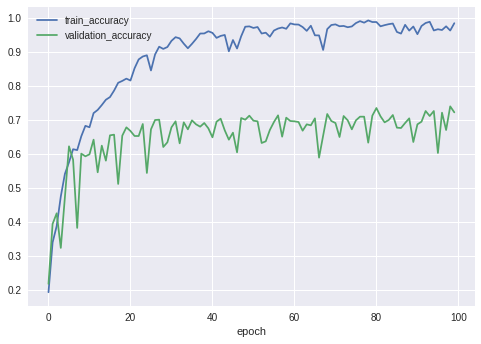

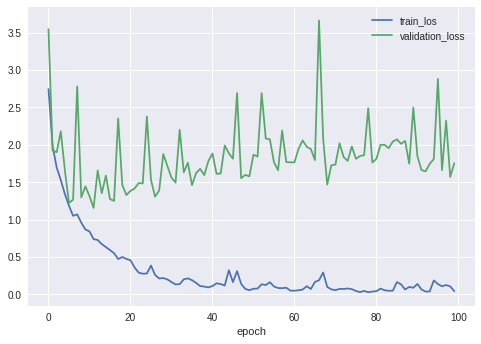

In [0]:
aclosplot('test00.csv')

# Activation Relu を Swish に変更<BR>エポック数を100に

In [0]:
"""
サンプルのモデルの定義と訓練を行うモジュール
vgg16をベースにした転移学習モデルとなっている。
"""
from keras.models import Model,Sequential
import tensorflow as tf
from keras.layers.convolutional import Conv2D
from keras.layers import Activation, Dense, GlobalAveragePooling2D, Input, InputLayer, Lambda, Dropout, BatchNormalization,LeakyReLU
from keras.backend import sigmoid
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam
from keras.callbacks import CSVLogger
from keras.callbacks import TensorBoard, EarlyStopping
import sys
import numpy as np
from collections import Counter
import continue_fit as cf
from keras.utils import multi_gpu_model
from keras import regularizers
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K

# Swishの定義
# http://yusuke-ujitoko.hatenablog.com/entry/2017/10/21/131232
# https://qiita.com/kiakiraki/items/2ec24f13ee870e13a0fb
def swish(x):
    return x * K.sigmoid(x)

def vgg_based_model(input_shape, n_categories, fulltraining = False):
    """
    VGG16をベースにした転移学習モデルを生成する。
    fulltraining: Trueにすると、ベースモデルも含めて訓練可能にする。訓練速度が非常に遅くなる。
    """
    base_model=VGG16(weights='imagenet',include_top=False,
                    input_tensor=Input(shape=input_shape))

    #add new layers instead of FC networks
    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(1024)(x)
    x=BatchNormalization()(x)
    x=Activation(swish)(x)
    x=Dropout(0.6)(x)
    x=Dense(1024)(x)
    x=BatchNormalization()(x)
    x=Activation(swish)(x)
    x=Dropout(0.6)(x)
    prediction=Dense(n_categories,activation='softmax')(x)
    model=Model(inputs=base_model.input,outputs=prediction)

    if not fulltraining:
        # fix weights before VGG16 14layers
        for layer in base_model.layers[:15]:
            layer.trainable=False
    return model


Using TensorFlow backend.


In [0]:
# コマンドライン引数の定義/評価
batch_size=32
input_shape = (224,224,3)
#  parser = argparse.ArgumentParser()
# parser.add_argument("model_name", help="保存するモデルファイルの名前、兼tensorBoardのログディレクトリ名")
# parser.add_argument("-t", "--train_dir", default='resized_cleaned', help="トレーニングデータセットが入っているディレクトリ")
# parser.add_argument("-v","--validation_dir",default='resized_val', help ="バリデーションデータセットが入っているディレクトリ")
# args = parser.parse_args()


file_name = 'test09' #args.model_name
train_dir= 'resized_cleaned' # args.train_dir
validation_dir= 'resized_val' # args.validation_dir

#訓練データの読み込み及びデータ拡張を行うための画像ジェネレータを生成。
#VGG16用の前処理及び平行移動、回転、左右反転、シアー変換をランダムにかける。
train_datagen=ImageDataGenerator(
    preprocessing_function=preprocess_input, #VGG16の前処理
    height_shift_range=0.02,
    width_shift_range=0.02,
    shear_range=0.05,
    zoom_range=0.05,
    rotation_range=5,
    horizontal_flip=True,
    )
train_generator=train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[0:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
    )


n_categories=len(train_generator.class_indices)
#サンプルの多いクラスに予測が集中しないように、少ないサンプルのクラスほど重くなるように重みづけ
class_weight ={ clss: len(train_generator.classes) / len(train_generator.class_indices) / count
                 for (clss,count) in Counter(train_generator.classes).most_common() }
print("classes:",train_generator.class_indices)
print("class weight:",class_weight)

#バリデーションデータの画像読み込み処理を行うジェネレータを生成
validation_datagen=ImageDataGenerator(
    preprocessing_function=preprocess_input,
    )
validation_generator=validation_datagen.flow_from_directory(
    validation_dir,
    target_size=input_shape[0:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

model = vgg_based_model(input_shape, n_categories)
# parallel_model = multi_gpu_model(model, gpus=2)   #マルチGPUを使うときはこちら

model.compile(optimizer=Adam(lr=1e-3),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

#訓練(中断しても続きから継続できる)
hist=model.fit_generator(
    train_generator,
    epochs=100,
    #initial_epoch=cf.load_epoch_init(file_name), # 同じモデル名でも結果を引き継がないようにコメントアウト
    # use_multiprocessing=True,
    verbose=1,
    workers=8,
    validation_data=validation_generator,
    class_weight=class_weight,
    callbacks=[
        CSVLogger(file_name+'.csv'),
        TensorBoard(file_name),
        cf.early_stopping(model, file_name),
        ])

Found 5234 images belonging to 11 classes.
classes: {'ALC板': 0, 'ガラスカーテンウォール': 1, 'ガラスブロック': 2, 'コンクリートブロック': 3, 'コンクリート打ち放し': 4, 'スパンドレル': 5, 'スレート波板張り': 6, 'タイル張り': 7, '吹付タイル': 8, '押出成形セメント板': 9, '石張り': 10}
class weight: {7: 0.38527788001472213, 1: 0.48701963338606125, 3: 0.6000229278917804, 4: 0.8994672624162227, 5: 0.967110125646711, 0: 1.310793889306286, 2: 1.6295143212951433, 9: 2.0687747035573123, 8: 2.44009324009324, 10: 5.4070247933884295, 6: 11.895454545454545}
Found 1020 images belonging to 11 classes.
Epoch 1/100
161/164 [============================>.] - ETA: 1s - loss: 2.5159 - acc: 0.2284

164/164 [==============================] - 85s 515ms/step - loss: 2.5106 - acc: 0.2282 - val_loss: 3.4377 - val_acc: 0.1500
Epoch 2/100
164/164 [==============================] - 78s 478ms/step - loss: 1.9340 - acc: 0.3428 - val_loss: 2.5502 - val_acc: 0.3392
Epoch 3/100
164/164 [==============================] - 79s 479ms/step - loss: 1.5807 - acc: 0.4426 - val_loss: 2.2835 - val_acc: 0.3157
Epoch 4/100
 11/164 [=>............................] - ETA: 53s - loss: 1.3349 - acc: 0.4858

164/164 [==============================] - 78s 476ms/step - loss: 1.3583 - acc: 0.5205 - val_loss: 1.5018 - val_acc: 0.5343
Epoch 5/100
164/164 [==============================] - 78s 477ms/step - loss: 1.2780 - acc: 0.5647 - val_loss: 1.7902 - val_acc: 0.4510
Epoch 6/100
147/164 [=========================>....] - ETA: 7s - loss: 1.0991 - acc: 0.6134

164/164 [==============================] - 78s 475ms/step - loss: 1.1030 - acc: 0.6104 - val_loss: 1.5012 - val_acc: 0.5500
Epoch 7/100
164/164 [==============================] - 78s 478ms/step - loss: 0.9633 - acc: 0.6453 - val_loss: 1.2924 - val_acc: 0.5931
Epoch 8/100
164/164 [==============================] - 79s 483ms/step - loss: 0.9348 - acc: 0.6604 - val_loss: 1.3387 - val_acc: 0.5735
Epoch 9/100
  9/164 [>.............................] - ETA: 53s - loss: 0.8170 - acc: 0.7083

164/164 [==============================] - 79s 479ms/step - loss: 0.8140 - acc: 0.6922 - val_loss: 1.7545 - val_acc: 0.5206
Epoch 10/100
164/164 [==============================] - 78s 477ms/step - loss: 0.7935 - acc: 0.7105 - val_loss: 1.2687 - val_acc: 0.6118
Epoch 11/100
145/164 [=========================>....] - ETA: 7s - loss: 0.7086 - acc: 0.7369

164/164 [==============================] - 79s 479ms/step - loss: 0.7124 - acc: 0.7323 - val_loss: 1.3417 - val_acc: 0.6108
Epoch 12/100
164/164 [==============================] - 79s 480ms/step - loss: 0.6695 - acc: 0.7476 - val_loss: 1.2811 - val_acc: 0.6333
Epoch 13/100
164/164 [==============================] - 79s 481ms/step - loss: 0.5859 - acc: 0.7768 - val_loss: 1.3433 - val_acc: 0.6235
Epoch 14/100
  7/164 [>.............................] - ETA: 54s - loss: 0.6613 - acc: 0.7232

164/164 [==============================] - 79s 479ms/step - loss: 0.5672 - acc: 0.7828 - val_loss: 1.2026 - val_acc: 0.6725
Epoch 15/100
164/164 [==============================] - 79s 479ms/step - loss: 0.5420 - acc: 0.7933 - val_loss: 1.2432 - val_acc: 0.6549
Epoch 16/100
144/164 [=========================>....] - ETA: 8s - loss: 0.4414 - acc: 0.8264

164/164 [==============================] - 78s 475ms/step - loss: 0.4520 - acc: 0.8224 - val_loss: 1.5667 - val_acc: 0.5902
Epoch 17/100
164/164 [==============================] - 79s 484ms/step - loss: 0.3568 - acc: 0.8505 - val_loss: 1.2555 - val_acc: 0.6735
Epoch 18/100
164/164 [==============================] - 78s 477ms/step - loss: 0.3636 - acc: 0.8515 - val_loss: 1.7779 - val_acc: 0.5824
Epoch 19/100
  7/164 [>.............................] - ETA: 53s - loss: 0.3349 - acc: 0.8438

164/164 [==============================] - 78s 477ms/step - loss: 0.3130 - acc: 0.8703 - val_loss: 6.6353 - val_acc: 0.3078
Epoch 20/100
164/164 [==============================] - 79s 479ms/step - loss: 0.3362 - acc: 0.8670 - val_loss: 1.8243 - val_acc: 0.6069
Epoch 21/100
144/164 [=========================>....] - ETA: 8s - loss: 0.2659 - acc: 0.8871

164/164 [==============================] - 79s 480ms/step - loss: 0.2786 - acc: 0.8841 - val_loss: 2.0668 - val_acc: 0.5529
Epoch 22/100
164/164 [==============================] - 79s 480ms/step - loss: 0.3479 - acc: 0.8714 - val_loss: 1.6305 - val_acc: 0.6284
Epoch 23/100
164/164 [==============================] - 79s 480ms/step - loss: 0.2980 - acc: 0.8795 - val_loss: 1.4232 - val_acc: 0.6706
Epoch 24/100
  7/164 [>.............................] - ETA: 53s - loss: 0.2666 - acc: 0.9107

164/164 [==============================] - 79s 480ms/step - loss: 0.2790 - acc: 0.9006 - val_loss: 1.8778 - val_acc: 0.6451
Epoch 25/100
164/164 [==============================] - 79s 479ms/step - loss: 0.2266 - acc: 0.8985 - val_loss: 1.2901 - val_acc: 0.7147
Epoch 26/100
144/164 [=========================>....] - ETA: 8s - loss: 0.1363 - acc: 0.9323

164/164 [==============================] - 78s 477ms/step - loss: 0.1838 - acc: 0.9230 - val_loss: 2.6505 - val_acc: 0.5627
Epoch 27/100
164/164 [==============================] - 79s 480ms/step - loss: 0.2645 - acc: 0.8920 - val_loss: 1.6489 - val_acc: 0.6588
Epoch 28/100
164/164 [==============================] - 78s 476ms/step - loss: 0.1510 - acc: 0.9268 - val_loss: 1.5425 - val_acc: 0.6961
Epoch 29/100
  7/164 [>.............................] - ETA: 53s - loss: 0.1376 - acc: 0.9598

164/164 [==============================] - 78s 478ms/step - loss: 0.2882 - acc: 0.8960 - val_loss: 1.5118 - val_acc: 0.6902
Epoch 30/100
164/164 [==============================] - 79s 479ms/step - loss: 0.1581 - acc: 0.9368 - val_loss: 1.7405 - val_acc: 0.6745
Epoch 31/100
144/164 [=========================>....] - ETA: 8s - loss: 0.1433 - acc: 0.9389

164/164 [==============================] - 78s 478ms/step - loss: 0.1520 - acc: 0.9341 - val_loss: 1.7119 - val_acc: 0.6706
Epoch 32/100
164/164 [==============================] - 78s 476ms/step - loss: 0.1100 - acc: 0.9526 - val_loss: 1.7263 - val_acc: 0.6853
Epoch 33/100
164/164 [==============================] - 78s 476ms/step - loss: 0.0991 - acc: 0.9569 - val_loss: 1.6343 - val_acc: 0.6941
Epoch 34/100
  7/164 [>.............................] - ETA: 53s - loss: 0.0705 - acc: 0.9688

164/164 [==============================] - 78s 476ms/step - loss: 0.1039 - acc: 0.9583 - val_loss: 1.7654 - val_acc: 0.6686
Epoch 35/100
164/164 [==============================] - 77s 468ms/step - loss: 0.0865 - acc: 0.9653 - val_loss: 1.5498 - val_acc: 0.7284
Epoch 36/100
144/164 [=========================>....] - ETA: 8s - loss: 0.0703 - acc: 0.9705

164/164 [==============================] - 77s 471ms/step - loss: 0.0837 - acc: 0.9664 - val_loss: 1.5666 - val_acc: 0.6980
Epoch 37/100
164/164 [==============================] - 78s 473ms/step - loss: 0.0827 - acc: 0.9647 - val_loss: 1.6545 - val_acc: 0.6882
Epoch 38/100
164/164 [==============================] - 77s 469ms/step - loss: 0.0698 - acc: 0.9743 - val_loss: 1.6279 - val_acc: 0.6794
Epoch 39/100
  7/164 [>.............................] - ETA: 53s - loss: 0.0660 - acc: 0.9554

164/164 [==============================] - 77s 470ms/step - loss: 0.1097 - acc: 0.9585 - val_loss: 2.0319 - val_acc: 0.6382
Epoch 40/100
164/164 [==============================] - 77s 470ms/step - loss: 0.1610 - acc: 0.9339 - val_loss: 1.8062 - val_acc: 0.6814
Epoch 41/100
144/164 [=========================>....] - ETA: 8s - loss: 0.1639 - acc: 0.9462

164/164 [==============================] - 77s 471ms/step - loss: 0.1598 - acc: 0.9480 - val_loss: 1.6563 - val_acc: 0.6961
Epoch 42/100
164/164 [==============================] - 77s 471ms/step - loss: 0.0869 - acc: 0.9644 - val_loss: 1.9489 - val_acc: 0.6549
Epoch 43/100
164/164 [==============================] - 77s 468ms/step - loss: 0.1452 - acc: 0.9528 - val_loss: 2.0528 - val_acc: 0.6559
Epoch 44/100
  7/164 [>.............................] - ETA: 53s - loss: 0.1114 - acc: 0.9643

164/164 [==============================] - 77s 468ms/step - loss: 0.0932 - acc: 0.9585 - val_loss: 2.1039 - val_acc: 0.6363
Epoch 45/100
164/164 [==============================] - 77s 469ms/step - loss: 0.2577 - acc: 0.9269 - val_loss: 2.1426 - val_acc: 0.6441
Epoch 46/100
144/164 [=========================>....] - ETA: 8s - loss: 0.1323 - acc: 0.9493

164/164 [==============================] - 77s 471ms/step - loss: 0.1277 - acc: 0.9499 - val_loss: 1.5335 - val_acc: 0.7108
Epoch 47/100
164/164 [==============================] - 78s 475ms/step - loss: 0.0764 - acc: 0.9693 - val_loss: 1.5471 - val_acc: 0.6941
Epoch 48/100
164/164 [==============================] - 78s 473ms/step - loss: 0.0535 - acc: 0.9772 - val_loss: 1.6168 - val_acc: 0.7078
Epoch 49/100
  7/164 [>.............................] - ETA: 54s - loss: 0.0428 - acc: 0.9866

164/164 [==============================] - 77s 469ms/step - loss: 0.0505 - acc: 0.9830 - val_loss: 2.4380 - val_acc: 0.6206
Epoch 50/100
164/164 [==============================] - 77s 469ms/step - loss: 0.2692 - acc: 0.9136 - val_loss: 1.6961 - val_acc: 0.6902
Epoch 51/100
144/164 [=========================>....] - ETA: 8s - loss: 0.0823 - acc: 0.9666

164/164 [==============================] - 77s 469ms/step - loss: 0.0950 - acc: 0.9669 - val_loss: 1.9122 - val_acc: 0.6608
Epoch 52/100
164/164 [==============================] - 77s 469ms/step - loss: 0.0784 - acc: 0.9669 - val_loss: 1.8820 - val_acc: 0.6637
Epoch 53/100
164/164 [==============================] - 77s 468ms/step - loss: 0.0476 - acc: 0.9800 - val_loss: 1.9231 - val_acc: 0.6569
Epoch 54/100
  7/164 [>.............................] - ETA: 54s - loss: 0.0774 - acc: 0.9643

164/164 [==============================] - 78s 478ms/step - loss: 0.0544 - acc: 0.9786 - val_loss: 1.9318 - val_acc: 0.6794
Epoch 55/100
164/164 [==============================] - 78s 477ms/step - loss: 0.0588 - acc: 0.9779 - val_loss: 1.6166 - val_acc: 0.7186
Epoch 56/100
144/164 [=========================>....] - ETA: 8s - loss: 0.0433 - acc: 0.9817

164/164 [==============================] - 78s 477ms/step - loss: 0.0455 - acc: 0.9810 - val_loss: 1.7622 - val_acc: 0.6794
Epoch 57/100
164/164 [==============================] - 78s 476ms/step - loss: 0.1307 - acc: 0.9556 - val_loss: 2.2586 - val_acc: 0.6716
Epoch 58/100
164/164 [==============================] - 78s 477ms/step - loss: 0.0801 - acc: 0.9687 - val_loss: 1.8849 - val_acc: 0.6873
Epoch 59/100
  7/164 [>.............................] - ETA: 53s - loss: 0.0559 - acc: 0.9732

164/164 [==============================] - 78s 477ms/step - loss: 0.0455 - acc: 0.9836 - val_loss: 1.7670 - val_acc: 0.6824
Epoch 60/100
164/164 [==============================] - 79s 479ms/step - loss: 0.0491 - acc: 0.9829 - val_loss: 2.0121 - val_acc: 0.6863
Epoch 61/100
144/164 [=========================>....] - ETA: 8s - loss: 0.0689 - acc: 0.9740

164/164 [==============================] - 78s 476ms/step - loss: 0.0641 - acc: 0.9752 - val_loss: 1.9047 - val_acc: 0.7010
Epoch 62/100
164/164 [==============================] - 78s 475ms/step - loss: 0.1324 - acc: 0.9623 - val_loss: 1.7505 - val_acc: 0.6804
Epoch 63/100
164/164 [==============================] - 78s 478ms/step - loss: 0.0680 - acc: 0.9756 - val_loss: 1.6939 - val_acc: 0.7118
Epoch 64/100
  7/164 [>.............................] - ETA: 54s - loss: 0.0714 - acc: 0.9777

164/164 [==============================] - 78s 478ms/step - loss: 0.0470 - acc: 0.9821 - val_loss: 1.9851 - val_acc: 0.6863
Epoch 65/100
164/164 [==============================] - 79s 479ms/step - loss: 0.0410 - acc: 0.9869 - val_loss: 1.6953 - val_acc: 0.7137
Epoch 66/100
144/164 [=========================>....] - ETA: 8s - loss: 0.1744 - acc: 0.9430

164/164 [==============================] - 79s 479ms/step - loss: 0.1610 - acc: 0.9457 - val_loss: 1.7631 - val_acc: 0.7098
Epoch 67/100
164/164 [==============================] - 79s 480ms/step - loss: 0.0621 - acc: 0.9747 - val_loss: 1.8053 - val_acc: 0.7069
Epoch 68/100
164/164 [==============================] - 78s 478ms/step - loss: 0.0463 - acc: 0.9818 - val_loss: 1.8206 - val_acc: 0.6990
Epoch 69/100
  7/164 [>.............................] - ETA: 54s - loss: 0.0303 - acc: 0.9732

164/164 [==============================] - 79s 479ms/step - loss: 0.0798 - acc: 0.9732 - val_loss: 1.9260 - val_acc: 0.6892
Epoch 70/100
164/164 [==============================] - 78s 479ms/step - loss: 0.0519 - acc: 0.9852 - val_loss: 1.8546 - val_acc: 0.6833
Epoch 71/100
144/164 [=========================>....] - ETA: 8s - loss: 0.0416 - acc: 0.9857

164/164 [==============================] - 79s 479ms/step - loss: 0.0395 - acc: 0.9867 - val_loss: 1.6648 - val_acc: 0.7098
Epoch 72/100
164/164 [==============================] - 79s 481ms/step - loss: 0.0286 - acc: 0.9901 - val_loss: 1.7993 - val_acc: 0.7088
Epoch 73/100
164/164 [==============================] - 79s 479ms/step - loss: 0.0313 - acc: 0.9913 - val_loss: 1.8825 - val_acc: 0.7186
Epoch 74/100
  7/164 [>.............................] - ETA: 53s - loss: 0.0390 - acc: 0.9911

164/164 [==============================] - 79s 479ms/step - loss: 0.0443 - acc: 0.9858 - val_loss: 1.8880 - val_acc: 0.6990
Epoch 75/100
164/164 [==============================] - 79s 480ms/step - loss: 0.0626 - acc: 0.9795 - val_loss: 2.3845 - val_acc: 0.6529
Epoch 76/100
144/164 [=========================>....] - ETA: 8s - loss: 0.0550 - acc: 0.9798

164/164 [==============================] - 79s 480ms/step - loss: 0.0565 - acc: 0.9790 - val_loss: 2.0452 - val_acc: 0.6912
Epoch 77/100
164/164 [==============================] - 79s 483ms/step - loss: 0.0883 - acc: 0.9675 - val_loss: 2.2445 - val_acc: 0.6922
Epoch 78/100
164/164 [==============================] - 79s 481ms/step - loss: 0.2334 - acc: 0.9419 - val_loss: 2.7078 - val_acc: 0.6196
Epoch 79/100
  7/164 [>.............................] - ETA: 54s - loss: 0.3854 - acc: 0.8884

164/164 [==============================] - 79s 480ms/step - loss: 0.1549 - acc: 0.9456 - val_loss: 2.1641 - val_acc: 0.6657
Epoch 80/100
164/164 [==============================] - 79s 481ms/step - loss: 0.0542 - acc: 0.9771 - val_loss: 1.6186 - val_acc: 0.7216
Epoch 81/100
144/164 [=========================>....] - ETA: 8s - loss: 0.0608 - acc: 0.9779

164/164 [==============================] - 79s 479ms/step - loss: 0.0589 - acc: 0.9785 - val_loss: 1.8712 - val_acc: 0.6961
Epoch 82/100
164/164 [==============================] - 79s 479ms/step - loss: 0.0427 - acc: 0.9869 - val_loss: 1.7443 - val_acc: 0.7157
Epoch 83/100
164/164 [==============================] - 79s 482ms/step - loss: 0.0265 - acc: 0.9918 - val_loss: 1.7535 - val_acc: 0.7088
Epoch 84/100
  7/164 [>.............................] - ETA: 53s - loss: 0.0183 - acc: 0.9821

164/164 [==============================] - 79s 482ms/step - loss: 0.0238 - acc: 0.9891 - val_loss: 1.8100 - val_acc: 0.7020
Epoch 85/100
164/164 [==============================] - 78s 478ms/step - loss: 0.1031 - acc: 0.9667 - val_loss: 2.2932 - val_acc: 0.6824
Epoch 86/100
144/164 [=========================>....] - ETA: 8s - loss: 0.0996 - acc: 0.9661

164/164 [==============================] - 79s 480ms/step - loss: 0.1246 - acc: 0.9625 - val_loss: 2.7749 - val_acc: 0.6147
Epoch 87/100
164/164 [==============================] - 79s 481ms/step - loss: 0.2718 - acc: 0.9279 - val_loss: 1.8778 - val_acc: 0.6696
Epoch 88/100
164/164 [==============================] - 79s 480ms/step - loss: 0.0548 - acc: 0.9772 - val_loss: 1.8121 - val_acc: 0.6990
Epoch 89/100
  7/164 [>.............................] - ETA: 54s - loss: 0.0158 - acc: 0.9911

164/164 [==============================] - 78s 477ms/step - loss: 0.0980 - acc: 0.9702 - val_loss: 1.8388 - val_acc: 0.7059
Epoch 90/100
164/164 [==============================] - 79s 481ms/step - loss: 0.0410 - acc: 0.9836 - val_loss: 1.9519 - val_acc: 0.6961
Epoch 91/100
144/164 [=========================>....] - ETA: 8s - loss: 0.0245 - acc: 0.9918

164/164 [==============================] - 79s 480ms/step - loss: 0.0297 - acc: 0.9909 - val_loss: 1.7356 - val_acc: 0.7196
Epoch 92/100
164/164 [==============================] - 79s 482ms/step - loss: 0.0289 - acc: 0.9897 - val_loss: 1.8404 - val_acc: 0.7078
Epoch 93/100
164/164 [==============================] - 79s 479ms/step - loss: 0.0312 - acc: 0.9905 - val_loss: 2.0057 - val_acc: 0.7000
Epoch 94/100
  7/164 [>.............................] - ETA: 53s - loss: 0.0887 - acc: 0.9777

164/164 [==============================] - 78s 479ms/step - loss: 0.0327 - acc: 0.9891 - val_loss: 2.0281 - val_acc: 0.6784
Epoch 95/100
164/164 [==============================] - 79s 480ms/step - loss: 0.0518 - acc: 0.9878 - val_loss: 2.0129 - val_acc: 0.6902
Epoch 96/100
144/164 [=========================>....] - ETA: 8s - loss: 0.0280 - acc: 0.9890

164/164 [==============================] - 79s 480ms/step - loss: 0.0290 - acc: 0.9890 - val_loss: 1.8273 - val_acc: 0.7147
Epoch 97/100
164/164 [==============================] - 79s 480ms/step - loss: 0.0383 - acc: 0.9889 - val_loss: 1.9259 - val_acc: 0.7098
Epoch 98/100
164/164 [==============================] - 79s 482ms/step - loss: 0.0452 - acc: 0.9842 - val_loss: 1.9060 - val_acc: 0.7157
Epoch 99/100
  7/164 [>.............................] - ETA: 53s - loss: 0.0107 - acc: 0.9911

164/164 [==============================] - 79s 480ms/step - loss: 0.0358 - acc: 0.9888 - val_loss: 1.8146 - val_acc: 0.7029
Epoch 100/100
164/164 [==============================] - 79s 482ms/step - loss: 0.0327 - acc: 0.9880 - val_loss: 1.9830 - val_acc: 0.6922


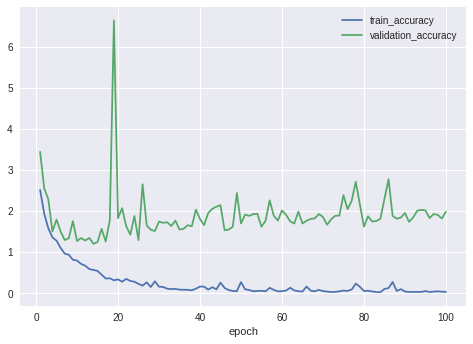

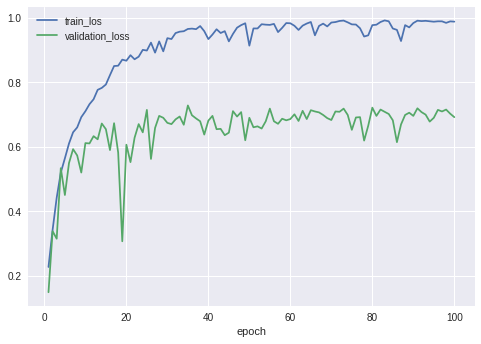

In [0]:
aclosplot('test09.csv')

# Activation Relu を LeakyReLU に変更して<BR>ImageDataGenerator パラメータ修正

- height_shift_range=5,
- width_shift_range=5,
- shear_range=0.05,
- zoom_range=0.95,
- rotation_range=7,


In [0]:
"""
サンプルのモデルの定義と訓練を行うモジュール
vgg16をベースにした転移学習モデルとなっている。
"""
from keras.models import Model,Sequential
import tensorflow as tf
from keras.layers.convolutional import Conv2D
from keras.layers import Activation, Dense, GlobalAveragePooling2D, Input, InputLayer, Lambda, Dropout, BatchNormalization,LeakyReLU
from keras.backend import sigmoid
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam
from keras.callbacks import CSVLogger
from keras.callbacks import TensorBoard, EarlyStopping
import sys
import numpy as np
from collections import Counter
import continue_fit as cf
from keras.utils import multi_gpu_model
from keras import regularizers
from keras.layers.advanced_activations import LeakyReLU

def vgg_based_model(input_shape, n_categories, fulltraining = False):
    """
    VGG16をベースにした転移学習モデルを生成する。
    fulltraining: Trueにすると、ベースモデルも含めて訓練可能にする。訓練速度が非常に遅くなる。
    """
    base_model=VGG16(weights='imagenet',include_top=False,
                    input_tensor=Input(shape=input_shape))

    #add new layers instead of FC networks
    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(1024)(x)
    x=BatchNormalization()(x)
    x=Activation(LeakyReLU())(x)
    x=Dropout(0.6)(x)
    x=Dense(1024)(x)
    x=BatchNormalization()(x)
    x=Activation(LeakyReLU())(x)
    x=Dropout(0.6)(x)
    prediction=Dense(n_categories,activation='softmax')(x)
    model=Model(inputs=base_model.input,outputs=prediction)

    if not fulltraining:
        # fix weights before VGG16 14layers
        for layer in base_model.layers[:15]:
            layer.trainable=False
    return model


In [0]:
# コマンドライン引数の定義/評価
batch_size=32
input_shape = (224,224,3)
#  parser = argparse.ArgumentParser()
# parser.add_argument("model_name", help="保存するモデルファイルの名前、兼tensorBoardのログディレクトリ名")
# parser.add_argument("-t", "--train_dir", default='resized_cleaned', help="トレーニングデータセットが入っているディレクトリ")
# parser.add_argument("-v","--validation_dir",default='resized_val', help ="バリデーションデータセットが入っているディレクトリ")
# args = parser.parse_args()


file_name = 'test10' #args.model_name
train_dir= 'resized_cleaned' # args.train_dir
validation_dir= 'resized_val' # args.validation_dir

#訓練データの読み込み及びデータ拡張を行うための画像ジェネレータを生成。
#VGG16用の前処理及び平行移動、回転、左右反転、シアー変換をランダムにかける。
train_datagen=ImageDataGenerator(
    preprocessing_function=preprocess_input, #VGG16の前処理
    height_shift_range=5,
    width_shift_range=5,
    shear_range=0.05,
    zoom_range=0.95,
    rotation_range=7,
    horizontal_flip=True,
    )
train_generator=train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[0:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
    )


n_categories=len(train_generator.class_indices)
#サンプルの多いクラスに予測が集中しないように、少ないサンプルのクラスほど重くなるように重みづけ
class_weight ={ clss: len(train_generator.classes) / len(train_generator.class_indices) / count
                 for (clss,count) in Counter(train_generator.classes).most_common() }
print("classes:",train_generator.class_indices)
print("class weight:",class_weight)

#バリデーションデータの画像読み込み処理を行うジェネレータを生成
validation_datagen=ImageDataGenerator(
    preprocessing_function=preprocess_input,
    )
validation_generator=validation_datagen.flow_from_directory(
    validation_dir,
    target_size=input_shape[0:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

model = vgg_based_model(input_shape, n_categories)
# parallel_model = multi_gpu_model(model, gpus=2)   #マルチGPUを使うときはこちら

model.compile(optimizer=Adam(lr=1e-3),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

#訓練(中断しても続きから継続できる)
hist=model.fit_generator(
    train_generator,
    epochs=100,
    #initial_epoch=cf.load_epoch_init(file_name), # 同じモデル名でも結果を引き継がないようにコメントアウト
    # use_multiprocessing=True,
    verbose=1,
    workers=8,
    validation_data=validation_generator,
    class_weight=class_weight,
    callbacks=[
        CSVLogger(file_name+'.csv'),
        TensorBoard(file_name),
        # cf.early_stopping(model, file_name),
        ])

Found 5234 images belonging to 11 classes.
classes: {'ALC板': 0, 'ガラスカーテンウォール': 1, 'ガラスブロック': 2, 'コンクリートブロック': 3, 'コンクリート打ち放し': 4, 'スパンドレル': 5, 'スレート波板張り': 6, 'タイル張り': 7, '吹付タイル': 8, '押出成形セメント板': 9, '石張り': 10}
class weight: {7: 0.38527788001472213, 1: 0.48701963338606125, 3: 0.6000229278917804, 4: 0.8994672624162227, 5: 0.967110125646711, 0: 1.310793889306286, 2: 1.6295143212951433, 9: 2.0687747035573123, 8: 2.44009324009324, 10: 5.4070247933884295, 6: 11.895454545454545}
Found 1020 images belonging to 11 classes.


/usr/local/lib/python3.6/dist-packages/keras/activations.py:115: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Epoch 1/100
164/164 [==============================] - 87s 527ms/step - loss: 3.1346 - acc: 0.1253 - val_loss: 2.3139 - val_acc: 0.2422
Epoch 2/100
164/164 [==============================] - 81s 494ms/step - loss: 2.5021 - acc: 0.2020 - val_loss: 3.6806 - val_acc: 0.1637
Epoch 3/100
129/164 [======================>.......] - ETA: 15s - loss: 2.5000 - acc: 0.1853

164/164 [==============================] - 83s 504ms/step - loss: 2.4294 - acc: 0.2031 - val_loss: 2.2228 - val_acc: 0.3529
Epoch 4/100
164/164 [==============================] - 84s 511ms/step - loss: 2.0443 - acc: 0.2688 - val_loss: 2.5159 - val_acc: 0.2598
Epoch 5/100
164/164 [==============================] - 81s 495ms/step - loss: 2.1067 - acc: 0.2688 - val_loss: 2.0744 - val_acc: 0.3598
Epoch 6/100
  6/164 [>.............................] - ETA: 55s - loss: 1.7584 - acc: 0.3542

164/164 [==============================] - 82s 503ms/step - loss: 1.9633 - acc: 0.3264 - val_loss: 1.8659 - val_acc: 0.3451
Epoch 7/100
164/164 [==============================] - 82s 500ms/step - loss: 1.8616 - acc: 0.3562 - val_loss: 2.0443 - val_acc: 0.4069
Epoch 8/100
146/164 [=========================>....] - ETA: 7s - loss: 1.7183 - acc: 0.4018

164/164 [==============================] - 83s 503ms/step - loss: 1.7185 - acc: 0.4049 - val_loss: 1.8021 - val_acc: 0.4382
Epoch 9/100
164/164 [==============================] - 82s 502ms/step - loss: 1.6448 - acc: 0.4245 - val_loss: 1.7994 - val_acc: 0.4578
Epoch 10/100
164/164 [==============================] - 83s 505ms/step - loss: 1.6142 - acc: 0.4519 - val_loss: 1.6781 - val_acc: 0.4873
Epoch 11/100
  8/164 [>.............................] - ETA: 54s - loss: 1.8313 - acc: 0.4414

164/164 [==============================] - 83s 505ms/step - loss: 1.5677 - acc: 0.4415 - val_loss: 1.6786 - val_acc: 0.4647
Epoch 12/100
164/164 [==============================] - 82s 503ms/step - loss: 1.4918 - acc: 0.4698 - val_loss: 1.4227 - val_acc: 0.5363
Epoch 13/100
145/164 [=========================>....] - ETA: 8s - loss: 1.4494 - acc: 0.4773

164/164 [==============================] - 82s 503ms/step - loss: 1.4426 - acc: 0.4796 - val_loss: 1.6162 - val_acc: 0.5127
Epoch 14/100
164/164 [==============================] - 82s 503ms/step - loss: 1.4359 - acc: 0.4966 - val_loss: 1.5110 - val_acc: 0.4961
Epoch 15/100
164/164 [==============================] - 82s 499ms/step - loss: 1.4394 - acc: 0.4909 - val_loss: 1.3674 - val_acc: 0.5725
Epoch 16/100
  7/164 [>.............................] - ETA: 54s - loss: 1.3389 - acc: 0.5402

164/164 [==============================] - 83s 508ms/step - loss: 1.4626 - acc: 0.4969 - val_loss: 2.2852 - val_acc: 0.4137
Epoch 17/100
164/164 [==============================] - 83s 507ms/step - loss: 1.3668 - acc: 0.5311 - val_loss: 1.7695 - val_acc: 0.4588
Epoch 18/100
144/164 [=========================>....] - ETA: 8s - loss: 1.3145 - acc: 0.5304

164/164 [==============================] - 83s 508ms/step - loss: 1.2959 - acc: 0.5357 - val_loss: 1.2806 - val_acc: 0.6186
Epoch 19/100
164/164 [==============================] - 83s 508ms/step - loss: 1.3186 - acc: 0.5456 - val_loss: 1.2557 - val_acc: 0.6255
Epoch 20/100
164/164 [==============================] - 83s 509ms/step - loss: 1.2597 - acc: 0.5618 - val_loss: 1.3786 - val_acc: 0.6049
Epoch 21/100
  7/164 [>.............................] - ETA: 54s - loss: 1.3004 - acc: 0.5605

164/164 [==============================] - 84s 510ms/step - loss: 1.2432 - acc: 0.5596 - val_loss: 1.0936 - val_acc: 0.6745
Epoch 22/100
164/164 [==============================] - 83s 506ms/step - loss: 1.2186 - acc: 0.5868 - val_loss: 1.1759 - val_acc: 0.6922
Epoch 23/100
144/164 [=========================>....] - ETA: 8s - loss: 1.1591 - acc: 0.5818

164/164 [==============================] - 83s 507ms/step - loss: 1.1577 - acc: 0.5796 - val_loss: 1.3398 - val_acc: 0.6402
Epoch 24/100
164/164 [==============================] - 84s 509ms/step - loss: 1.1938 - acc: 0.5886 - val_loss: 1.1400 - val_acc: 0.6637
Epoch 25/100
164/164 [==============================] - 83s 507ms/step - loss: 1.1715 - acc: 0.5795 - val_loss: 1.4596 - val_acc: 0.5706
Epoch 26/100
  7/164 [>.............................] - ETA: 54s - loss: 1.3646 - acc: 0.5491

164/164 [==============================] - 83s 509ms/step - loss: 1.1334 - acc: 0.5948 - val_loss: 1.2823 - val_acc: 0.6578
Epoch 27/100
164/164 [==============================] - 83s 506ms/step - loss: 1.1374 - acc: 0.5971 - val_loss: 1.3934 - val_acc: 0.5941
Epoch 28/100
144/164 [=========================>....] - ETA: 8s - loss: 1.2023 - acc: 0.5807

164/164 [==============================] - 83s 507ms/step - loss: 1.1998 - acc: 0.5796 - val_loss: 1.4851 - val_acc: 0.5824
Epoch 29/100
164/164 [==============================] - 83s 504ms/step - loss: 1.0959 - acc: 0.6001 - val_loss: 1.1297 - val_acc: 0.6922
Epoch 30/100
164/164 [==============================] - 83s 507ms/step - loss: 1.1321 - acc: 0.6065 - val_loss: 1.1876 - val_acc: 0.6667
Epoch 31/100
  7/164 [>.............................] - ETA: 55s - loss: 1.0413 - acc: 0.6071

164/164 [==============================] - 84s 509ms/step - loss: 1.0809 - acc: 0.6185 - val_loss: 1.2982 - val_acc: 0.6608
Epoch 32/100
164/164 [==============================] - 83s 509ms/step - loss: 1.0329 - acc: 0.6245 - val_loss: 1.1659 - val_acc: 0.6755
Epoch 33/100
144/164 [=========================>....] - ETA: 8s - loss: 1.0822 - acc: 0.6044

164/164 [==============================] - 83s 507ms/step - loss: 1.0767 - acc: 0.6067 - val_loss: 1.2947 - val_acc: 0.6353
Epoch 34/100
164/164 [==============================] - 84s 510ms/step - loss: 1.0481 - acc: 0.6282 - val_loss: 1.1095 - val_acc: 0.7186
Epoch 35/100
164/164 [==============================] - 83s 508ms/step - loss: 1.0523 - acc: 0.6329 - val_loss: 1.1524 - val_acc: 0.6912
Epoch 36/100
  7/164 [>.............................] - ETA: 55s - loss: 1.0276 - acc: 0.6607

164/164 [==============================] - 83s 505ms/step - loss: 1.0363 - acc: 0.6266 - val_loss: 1.0900 - val_acc: 0.6941
Epoch 37/100
164/164 [==============================] - 83s 505ms/step - loss: 1.0191 - acc: 0.6339 - val_loss: 1.1484 - val_acc: 0.7078
Epoch 38/100
144/164 [=========================>....] - ETA: 8s - loss: 1.0357 - acc: 0.6311

164/164 [==============================] - 83s 506ms/step - loss: 1.0180 - acc: 0.6344 - val_loss: 1.2452 - val_acc: 0.6608
Epoch 39/100
164/164 [==============================] - 83s 504ms/step - loss: 0.9711 - acc: 0.6471 - val_loss: 1.1864 - val_acc: 0.6775
Epoch 40/100
164/164 [==============================] - 83s 505ms/step - loss: 1.0058 - acc: 0.6378 - val_loss: 1.1432 - val_acc: 0.7137
Epoch 41/100
  7/164 [>.............................] - ETA: 54s - loss: 0.8849 - acc: 0.6652

164/164 [==============================] - 83s 505ms/step - loss: 0.8677 - acc: 0.6796 - val_loss: 1.1696 - val_acc: 0.7029
Epoch 42/100
164/164 [==============================] - 83s 505ms/step - loss: 0.8945 - acc: 0.6633 - val_loss: 1.3352 - val_acc: 0.6431
Epoch 43/100
144/164 [=========================>....] - ETA: 8s - loss: 0.9436 - acc: 0.6586

164/164 [==============================] - 83s 507ms/step - loss: 0.9325 - acc: 0.6623 - val_loss: 1.1506 - val_acc: 0.7039
Epoch 44/100
164/164 [==============================] - 82s 499ms/step - loss: 0.8788 - acc: 0.6773 - val_loss: 1.0768 - val_acc: 0.7078
Epoch 45/100
164/164 [==============================] - 81s 496ms/step - loss: 0.8471 - acc: 0.6840 - val_loss: 1.1837 - val_acc: 0.7078
Epoch 46/100
  7/164 [>.............................] - ETA: 54s - loss: 0.8873 - acc: 0.6518

164/164 [==============================] - 81s 497ms/step - loss: 0.8684 - acc: 0.6810 - val_loss: 1.1726 - val_acc: 0.7078
Epoch 47/100
164/164 [==============================] - 81s 495ms/step - loss: 0.8689 - acc: 0.6855 - val_loss: 1.1947 - val_acc: 0.7078
Epoch 48/100
144/164 [=========================>....] - ETA: 8s - loss: 0.8978 - acc: 0.6744

164/164 [==============================] - 81s 495ms/step - loss: 0.8962 - acc: 0.6705 - val_loss: 1.3502 - val_acc: 0.6931
Epoch 49/100
164/164 [==============================] - 81s 494ms/step - loss: 0.8685 - acc: 0.6794 - val_loss: 1.2461 - val_acc: 0.6853
Epoch 50/100
164/164 [==============================] - 81s 494ms/step - loss: 0.8095 - acc: 0.6975 - val_loss: 1.2081 - val_acc: 0.7108
Epoch 51/100
  7/164 [>.............................] - ETA: 54s - loss: 0.5121 - acc: 0.7589

164/164 [==============================] - 81s 494ms/step - loss: 0.7909 - acc: 0.7072 - val_loss: 1.2658 - val_acc: 0.6804
Epoch 52/100
164/164 [==============================] - 80s 491ms/step - loss: 0.7937 - acc: 0.7136 - val_loss: 1.1401 - val_acc: 0.7206
Epoch 53/100
144/164 [=========================>....] - ETA: 8s - loss: 0.7789 - acc: 0.7042

164/164 [==============================] - 81s 496ms/step - loss: 0.8106 - acc: 0.6986 - val_loss: 1.2413 - val_acc: 0.6853
Epoch 54/100
164/164 [==============================] - 80s 490ms/step - loss: 0.7414 - acc: 0.7276 - val_loss: 1.2102 - val_acc: 0.7108
Epoch 55/100
164/164 [==============================] - 81s 492ms/step - loss: 0.7666 - acc: 0.7146 - val_loss: 1.3533 - val_acc: 0.6814
Epoch 56/100
  7/164 [>.............................] - ETA: 54s - loss: 0.7881 - acc: 0.7634

164/164 [==============================] - 81s 493ms/step - loss: 0.7182 - acc: 0.7161 - val_loss: 1.1684 - val_acc: 0.7196
Epoch 57/100
164/164 [==============================] - 81s 492ms/step - loss: 0.7645 - acc: 0.7183 - val_loss: 1.2608 - val_acc: 0.7147
Epoch 58/100
144/164 [=========================>....] - ETA: 8s - loss: 0.7154 - acc: 0.7284

164/164 [==============================] - 82s 497ms/step - loss: 0.7252 - acc: 0.7267 - val_loss: 1.1978 - val_acc: 0.7255
Epoch 59/100
164/164 [==============================] - 83s 507ms/step - loss: 0.7657 - acc: 0.7272 - val_loss: 1.2275 - val_acc: 0.7157
Epoch 60/100
164/164 [==============================] - 83s 506ms/step - loss: 0.7510 - acc: 0.7277 - val_loss: 1.4841 - val_acc: 0.6765
Epoch 61/100
  7/164 [>.............................] - ETA: 54s - loss: 0.9767 - acc: 0.6518

164/164 [==============================] - 82s 501ms/step - loss: 0.7498 - acc: 0.7198 - val_loss: 1.2684 - val_acc: 0.6725
Epoch 62/100
164/164 [==============================] - 81s 491ms/step - loss: 0.7184 - acc: 0.7312 - val_loss: 1.1901 - val_acc: 0.7324
Epoch 63/100
144/164 [=========================>....] - ETA: 8s - loss: 0.6933 - acc: 0.7434

164/164 [==============================] - 81s 496ms/step - loss: 0.6863 - acc: 0.7446 - val_loss: 1.3071 - val_acc: 0.7333
Epoch 64/100
164/164 [==============================] - 78s 475ms/step - loss: 0.6599 - acc: 0.7324 - val_loss: 1.3033 - val_acc: 0.7078
Epoch 65/100
164/164 [==============================] - 79s 481ms/step - loss: 0.6830 - acc: 0.7379 - val_loss: 1.2916 - val_acc: 0.7402
Epoch 66/100
  7/164 [>.............................] - ETA: 54s - loss: 0.9381 - acc: 0.7143

164/164 [==============================] - 79s 480ms/step - loss: 0.6720 - acc: 0.7425 - val_loss: 1.1209 - val_acc: 0.7510
Epoch 67/100
164/164 [==============================] - 79s 480ms/step - loss: 0.6720 - acc: 0.7449 - val_loss: 1.2930 - val_acc: 0.7343
Epoch 68/100
144/164 [=========================>....] - ETA: 8s - loss: 0.6977 - acc: 0.7398

164/164 [==============================] - 77s 472ms/step - loss: 0.7082 - acc: 0.7382 - val_loss: 1.2821 - val_acc: 0.7167
Epoch 69/100
164/164 [==============================] - 80s 488ms/step - loss: 0.6798 - acc: 0.7418 - val_loss: 1.1678 - val_acc: 0.7353
Epoch 70/100
164/164 [==============================] - 80s 485ms/step - loss: 0.6357 - acc: 0.7554 - val_loss: 1.2193 - val_acc: 0.7206
Epoch 71/100
  7/164 [>.............................] - ETA: 54s - loss: 0.5634 - acc: 0.7455

164/164 [==============================] - 79s 479ms/step - loss: 0.6563 - acc: 0.7555 - val_loss: 1.3978 - val_acc: 0.6990
Epoch 72/100
164/164 [==============================] - 79s 483ms/step - loss: 0.5918 - acc: 0.7653 - val_loss: 1.3536 - val_acc: 0.7255
Epoch 73/100
144/164 [=========================>....] - ETA: 8s - loss: 0.6174 - acc: 0.7640

164/164 [==============================] - 78s 476ms/step - loss: 0.6504 - acc: 0.7602 - val_loss: 1.4588 - val_acc: 0.7216
Epoch 74/100
164/164 [==============================] - 78s 473ms/step - loss: 0.6474 - acc: 0.7451 - val_loss: 1.3183 - val_acc: 0.7039
Epoch 75/100
164/164 [==============================] - 77s 470ms/step - loss: 0.6315 - acc: 0.7488 - val_loss: 1.6204 - val_acc: 0.6676
Epoch 76/100
  7/164 [>.............................] - ETA: 54s - loss: 0.6310 - acc: 0.7902

164/164 [==============================] - 77s 467ms/step - loss: 0.7102 - acc: 0.7480 - val_loss: 1.2798 - val_acc: 0.7324
Epoch 77/100
164/164 [==============================] - 77s 472ms/step - loss: 0.6507 - acc: 0.7550 - val_loss: 1.4077 - val_acc: 0.6941
Epoch 78/100
144/164 [=========================>....] - ETA: 8s - loss: 0.6429 - acc: 0.7598

164/164 [==============================] - 77s 469ms/step - loss: 0.6320 - acc: 0.7615 - val_loss: 1.3156 - val_acc: 0.7353
Epoch 79/100
164/164 [==============================] - 77s 471ms/step - loss: 0.6411 - acc: 0.7718 - val_loss: 1.2205 - val_acc: 0.7392
Epoch 80/100
164/164 [==============================] - 77s 469ms/step - loss: 0.5526 - acc: 0.7885 - val_loss: 1.4320 - val_acc: 0.6912
Epoch 81/100
  7/164 [>.............................] - ETA: 54s - loss: 0.4803 - acc: 0.7321

164/164 [==============================] - 77s 471ms/step - loss: 0.5999 - acc: 0.7703 - val_loss: 1.3060 - val_acc: 0.7324
Epoch 82/100
164/164 [==============================] - 76s 464ms/step - loss: 0.5827 - acc: 0.7817 - val_loss: 1.4157 - val_acc: 0.7333
Epoch 83/100
144/164 [=========================>....] - ETA: 8s - loss: 0.5696 - acc: 0.7776

164/164 [==============================] - 79s 483ms/step - loss: 0.5669 - acc: 0.7757 - val_loss: 1.7573 - val_acc: 0.6745
Epoch 84/100
164/164 [==============================] - 79s 484ms/step - loss: 0.5573 - acc: 0.7883 - val_loss: 1.4155 - val_acc: 0.7294
Epoch 85/100
164/164 [==============================] - 79s 484ms/step - loss: 0.6524 - acc: 0.7718 - val_loss: 2.0097 - val_acc: 0.6843
Epoch 86/100
  7/164 [>.............................] - ETA: 54s - loss: 0.5744 - acc: 0.7723

164/164 [==============================] - 80s 486ms/step - loss: 0.6054 - acc: 0.7685 - val_loss: 1.4371 - val_acc: 0.7186
Epoch 87/100
164/164 [==============================] - 77s 470ms/step - loss: 0.6349 - acc: 0.7681 - val_loss: 1.5069 - val_acc: 0.7098
Epoch 88/100
144/164 [=========================>....] - ETA: 8s - loss: 0.5371 - acc: 0.7898

164/164 [==============================] - 77s 469ms/step - loss: 0.5355 - acc: 0.7944 - val_loss: 1.3752 - val_acc: 0.7039
Epoch 89/100
164/164 [==============================] - 75s 459ms/step - loss: 0.5317 - acc: 0.7959 - val_loss: 1.3218 - val_acc: 0.7314
Epoch 90/100
164/164 [==============================] - 77s 470ms/step - loss: 0.5424 - acc: 0.7868 - val_loss: 1.3685 - val_acc: 0.7245
Epoch 91/100
  7/164 [>.............................] - ETA: 54s - loss: 0.5478 - acc: 0.7946

164/164 [==============================] - 76s 462ms/step - loss: 0.5493 - acc: 0.7948 - val_loss: 1.3845 - val_acc: 0.7294
Epoch 92/100
164/164 [==============================] - 77s 472ms/step - loss: 0.4939 - acc: 0.8012 - val_loss: 1.4533 - val_acc: 0.7206
Epoch 93/100
144/164 [=========================>....] - ETA: 8s - loss: 0.5247 - acc: 0.8020

164/164 [==============================] - 76s 464ms/step - loss: 0.5293 - acc: 0.7981 - val_loss: 1.5584 - val_acc: 0.6951
Epoch 94/100
164/164 [==============================] - 76s 462ms/step - loss: 0.5256 - acc: 0.7963 - val_loss: 1.5867 - val_acc: 0.6853
Epoch 95/100
164/164 [==============================] - 76s 465ms/step - loss: 0.5123 - acc: 0.7917 - val_loss: 1.5010 - val_acc: 0.7225
Epoch 96/100
  7/164 [>.............................] - ETA: 54s - loss: 0.4565 - acc: 0.8036

164/164 [==============================] - 78s 473ms/step - loss: 0.5059 - acc: 0.8097 - val_loss: 1.3112 - val_acc: 0.7294
Epoch 97/100
164/164 [==============================] - 76s 465ms/step - loss: 0.4986 - acc: 0.8058 - val_loss: 1.3231 - val_acc: 0.7363
Epoch 98/100
144/164 [=========================>....] - ETA: 8s - loss: 0.4918 - acc: 0.8066

164/164 [==============================] - 77s 471ms/step - loss: 0.4924 - acc: 0.8077 - val_loss: 1.2483 - val_acc: 0.7500
Epoch 99/100
164/164 [==============================] - 79s 479ms/step - loss: 0.5265 - acc: 0.8048 - val_loss: 1.3872 - val_acc: 0.7245
Epoch 100/100
164/164 [==============================] - 77s 469ms/step - loss: 0.4573 - acc: 0.8158 - val_loss: 1.4645 - val_acc: 0.7245


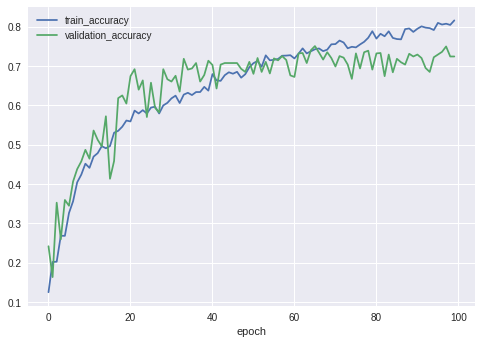

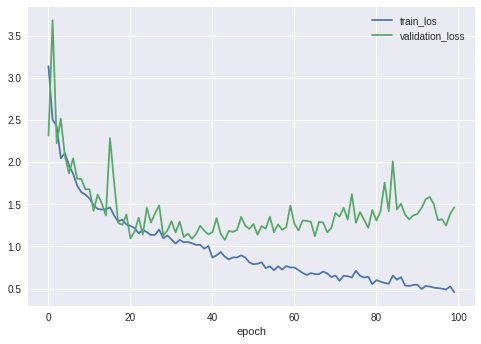

In [0]:
aclosplot('test10.csv')

# icrawler　で　それぞれ200枚収集<BR> Activation Relu を LeakyReLU に変更して<BR>ImageDataGenerator パラメータ修正

- height_shift_range=5,
- width_shift_range=5,
- shear_range=0.05,
- zoom_range=0.95,
- rotation_range=7,


In [0]:
"""
サンプルのモデルの定義と訓練を行うモジュール
vgg16をベースにした転移学習モデルとなっている。
"""
from keras.models import Model,Sequential
import tensorflow as tf
from keras.layers.convolutional import Conv2D
from keras.layers import Activation, Dense, GlobalAveragePooling2D, Input, InputLayer, Lambda, Dropout, BatchNormalization,LeakyReLU
from keras.backend import sigmoid
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam
from keras.callbacks import CSVLogger
from keras.callbacks import TensorBoard, EarlyStopping
import sys
import numpy as np
from collections import Counter
import continue_fit as cf
from keras.utils import multi_gpu_model
from keras import regularizers
from keras.layers.advanced_activations import LeakyReLU

def vgg_based_model(input_shape, n_categories, fulltraining = False):
    """
    VGG16をベースにした転移学習モデルを生成する。
    fulltraining: Trueにすると、ベースモデルも含めて訓練可能にする。訓練速度が非常に遅くなる。
    """
    base_model=VGG16(weights='imagenet',include_top=False,
                    input_tensor=Input(shape=input_shape))

    #add new layers instead of FC networks
    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(1024)(x)
    x=BatchNormalization()(x)
    x=Activation(LeakyReLU())(x)
    x=Dropout(0.6)(x)
    x=Dense(1024)(x)
    x=BatchNormalization()(x)
    x=Activation(LeakyReLU())(x)
    x=Dropout(0.6)(x)
    prediction=Dense(n_categories,activation='softmax')(x)
    model=Model(inputs=base_model.input,outputs=prediction)

    if not fulltraining:
        # fix weights before VGG16 14layers
        for layer in base_model.layers[:15]:
            layer.trainable=False
    return model


In [0]:
# コマンドライン引数の定義/評価
batch_size=32
input_shape = (224,224,3)
#  parser = argparse.ArgumentParser()
# parser.add_argument("model_name", help="保存するモデルファイルの名前、兼tensorBoardのログディレクトリ名")
# parser.add_argument("-t", "--train_dir", default='resized_cleaned', help="トレーニングデータセットが入っているディレクトリ")
# parser.add_argument("-v","--validation_dir",default='resized_val', help ="バリデーションデータセットが入っているディレクトリ")
# args = parser.parse_args()


file_name = 'test10' #args.model_name
train_dir= 'resized_cleaned' # args.train_dir
validation_dir= 'resized_val' # args.validation_dir

#訓練データの読み込み及びデータ拡張を行うための画像ジェネレータを生成。
#VGG16用の前処理及び平行移動、回転、左右反転、シアー変換をランダムにかける。
train_datagen=ImageDataGenerator(
    preprocessing_function=preprocess_input, #VGG16の前処理
    height_shift_range=5,
    width_shift_range=5,
    shear_range=0.05,
    zoom_range=0.95,
    rotation_range=7,
    horizontal_flip=True,
    )
train_generator=train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[0:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
    )


n_categories=len(train_generator.class_indices)
#サンプルの多いクラスに予測が集中しないように、少ないサンプルのクラスほど重くなるように重みづけ
class_weight ={ clss: len(train_generator.classes) / len(train_generator.class_indices) / count
                 for (clss,count) in Counter(train_generator.classes).most_common() }
print("classes:",train_generator.class_indices)
print("class weight:",class_weight)

#バリデーションデータの画像読み込み処理を行うジェネレータを生成
validation_datagen=ImageDataGenerator(
    preprocessing_function=preprocess_input,
    )
validation_generator=validation_datagen.flow_from_directory(
    validation_dir,
    target_size=input_shape[0:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

model = vgg_based_model(input_shape, n_categories)
# parallel_model = multi_gpu_model(model, gpus=2)   #マルチGPUを使うときはこちら

model.compile(optimizer=Adam(lr=1e-3),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

#訓練(中断しても続きから継続できる)
hist=model.fit_generator(
    train_generator,
    epochs=100,
    #initial_epoch=cf.load_epoch_init(file_name), # 同じモデル名でも結果を引き継がないようにコメントアウト
    # use_multiprocessing=True,
    verbose=1,
    workers=8,
    validation_data=validation_generator,
    class_weight=class_weight,
    callbacks=[
        CSVLogger(file_name+'.csv'),
        TensorBoard(file_name),
        # cf.early_stopping(model, file_name),
        ])

Found 7017 images belonging to 11 classes.
classes: {'ALC板': 0, 'ガラスカーテンウォール': 1, 'ガラスブロック': 2, 'コンクリートブロック': 3, 'コンクリート打ち放し': 4, 'スパンドレル': 5, 'スレート波板張り': 6, 'タイル張り': 7, '吹付タイル': 8, '押出成形セメント板': 9, '石張り': 10}
class weight: {7: 0.4582680250783699, 1: 0.5590789578519639, 3: 0.6603613777526821, 4: 0.9087024087024087, 5: 0.9813986013986014, 0: 1.2362579281183932, 2: 1.3989234449760766, 9: 1.6149597238204831, 8: 1.7573253193087903, 10: 2.5931263858093123, 6: 3.3574162679425834}
Found 1020 images belonging to 11 classes.


/usr/local/lib/python3.6/dist-packages/keras/activations.py:115: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Epoch 1/100
